# Berlin Transport Network - Data Verification

This notebook verifies the processed Berlin transport network data to ensure data quality and consistency. It performs the following checks:

1. **Transport Types**: Verifies that all transport types are in the allowed set (autobus, omnibus, tram, u-bahn, s-bahn, ferry/fähre, strassenbahn)
2. **Stop Uniqueness**: Ensures each combination of stop_name, line_name, and year is unique
3. **Stop Connections**: Checks that each stop has at least one connection and no more than two connections
4. **Referential Integrity**: Verifies that all line_stops references point to valid lines and stops
5. **Geographic Data**: Ensures all stops have geographic coordinates

The verification logic is implemented in the `src.verification` module.

In [17]:
import sys
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Import verification module
sys.path.append('..')
from src import verification

In [18]:
# Configuration
YEAR = 1965
SIDE = "west"
BASE_DIR = Path('../data')

In [19]:
# Run verification
results = verification.run_verification(BASE_DIR, YEAR, SIDE)

2025-04-06 23:56:29,136 - INFO - Loaded processed data: 102 lines, 1395 stops, 1395 line-stop relationships


In [20]:
# Generate and display report
report = verification.generate_verification_report(results, YEAR, SIDE)
print(report)

VERIFICATION REPORT: 1965 WEST

OVERALL STATUS: PASSED

1. Transport Types: PASSED

2. Stop Uniqueness: PASSED

3. Stop Connections: PASSED

4. Referential Integrity: PASSED

5. Geographic Data: PASSED

RECOMMENDATIONS:
  - No issues found! Data is ready for analysis.


In [21]:
# Display check results in a more compact form
print("Verification Checks Results:")
print(f"- Transport Types: {'✅ PASSED' if results['transport_types']['valid'] else '❌ FAILED'}")
print(f"- Stop Uniqueness: {'✅ PASSED' if results['stop_uniqueness']['valid'] else '❌ FAILED'}")
print(f"- Stop Connections: {'✅ PASSED' if results['stop_connections']['valid'] else '❌ FAILED'}")
print(f"- Referential Integrity: {'✅ PASSED' if results['referential_integrity']['valid'] else '❌ FAILED'}")
print(f"- Geographic Data: {'✅ PASSED' if results['geographic_data']['valid'] else '❌ FAILED'}")

Verification Checks Results:
- Transport Types: ✅ PASSED
- Stop Uniqueness: ✅ PASSED
- Stop Connections: ✅ PASSED
- Referential Integrity: ✅ PASSED
- Geographic Data: ✅ PASSED


### 1. Transport Types Analysis

Analyze the distribution of transport types and verify they are all valid.

2025-04-06 23:56:29,214 - INFO - Loaded processed data: 102 lines, 1395 stops, 1395 line-stop relationships


Valid transport types: {'tram', 'u-bahn', 'omnibus', 's-bahn', 'autobus', 'ferry'}

Transport types found in the data:
- autobus: 73 lines
- s-bahn: 10 lines
- tram: 9 lines
- u-bahn: 9 lines
- ferry: 1 lines


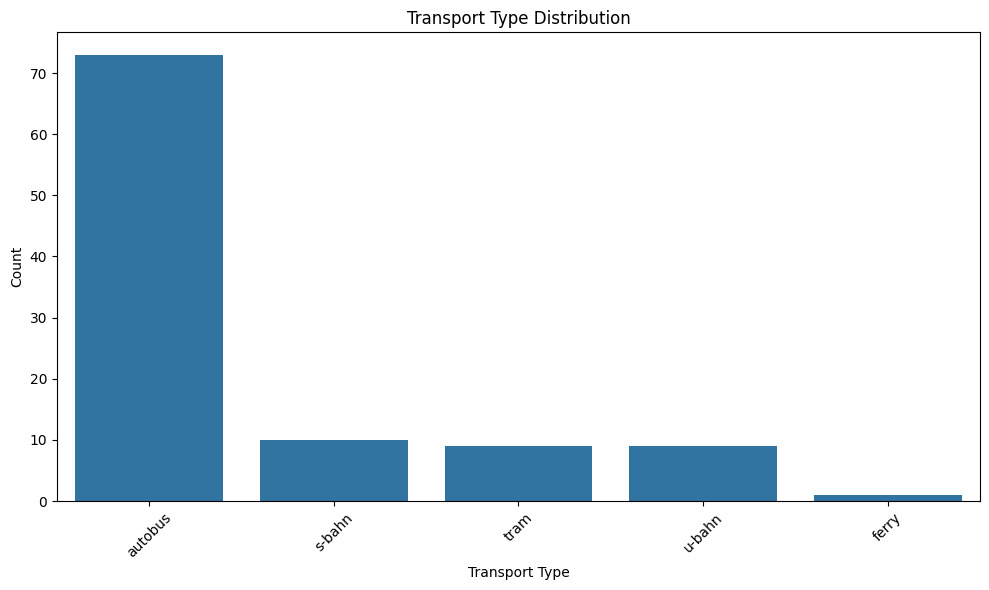

In [22]:
# Load the data again to analyze in more detail
data = verification.load_processed_data(BASE_DIR, YEAR, SIDE)
lines_df = data['lines']

# Display valid transport types
print(f"Valid transport types: {verification.VALID_TRANSPORT_TYPES}")
print()

# Analyze transport types
transport_counts = lines_df['type'].value_counts()
print("Transport types found in the data:")
for transport_type, count in transport_counts.items():
    print(f"- {transport_type}: {count} lines")

# Visualize transport type distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=transport_counts.index, y=transport_counts.values)
plt.title("Transport Type Distribution")
plt.xlabel("Transport Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2. Stop Connections Analysis

Analyze the number of connections per stop.

Connection counts:
- 1 connection: 1395 stops
- 2 connections: 0 stops
- 3+ connections: 0 stops
- Disconnected stops: 0 stops


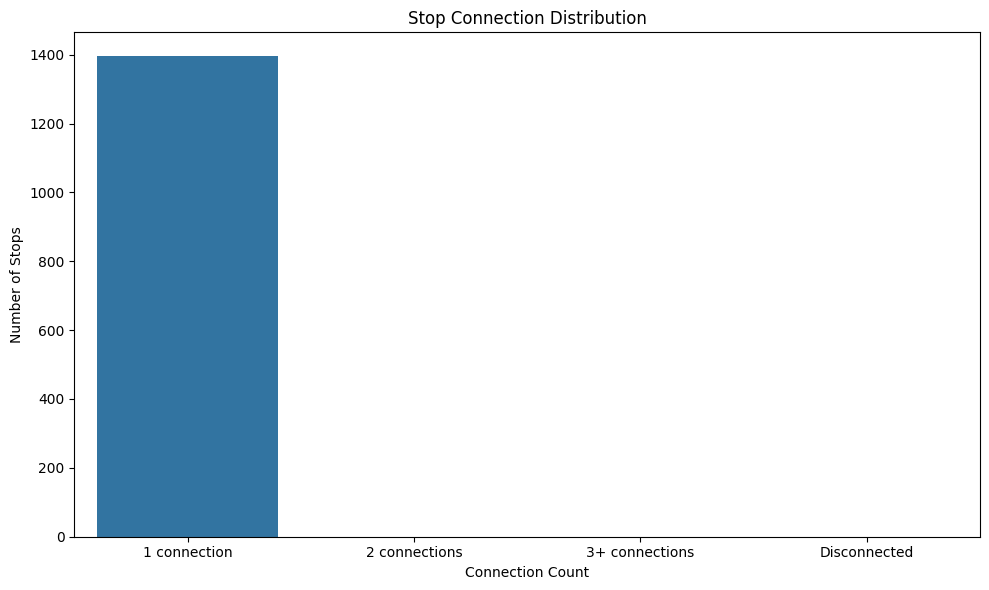

In [23]:
# Load data
stops_df = data['stops']
line_stops_df = data['line_stops']

# Count connections per stop
connection_counts = line_stops_df['stop_id'].value_counts().reset_index()
connection_counts.columns = ['stop_id', 'connection_count']

# Get counts by connection number
one_connection = len(connection_counts[connection_counts['connection_count'] == 1])
two_connections = len(connection_counts[connection_counts['connection_count'] == 2])
more_connections = len(connection_counts[connection_counts['connection_count'] > 2])

# Count disconnected stops
all_stop_ids = set(stops_df['stop_id'])
connected_stop_ids = set(line_stops_df['stop_id'])
disconnected_count = len(all_stop_ids - connected_stop_ids)

print("Connection counts:")
print(f"- 1 connection: {one_connection} stops")
print(f"- 2 connections: {two_connections} stops")
print(f"- 3+ connections: {more_connections} stops")
print(f"- Disconnected stops: {disconnected_count} stops")

# Visualize connection distribution
connection_distribution = pd.Series({
    "1 connection": one_connection,
    "2 connections": two_connections,
    "3+ connections": more_connections,
    "Disconnected": disconnected_count
})

plt.figure(figsize=(10, 6))
sns.barplot(x=connection_distribution.index, y=connection_distribution.values)
plt.title("Stop Connection Distribution")
plt.xlabel("Connection Count")
plt.ylabel("Number of Stops")
plt.tight_layout()
plt.show()

### 3. Examine Issues (if any)

If verification failed, examine the specific issues in more detail.

In [24]:
# Check for duplicate stops
if not results['stop_uniqueness']['valid']:
    print("DUPLICATE STOPS:")
    display(results['stop_uniqueness']['duplicates'].head(10))
    print(f"Showing 10 of {len(results['stop_uniqueness']['duplicates'])} duplicate stops")
    print()

# Check for disconnected stops
if results['stop_connections']['disconnected_count'] > 0:
    print("DISCONNECTED STOPS:")
    display(results['stop_connections']['disconnected'].head(10))
    print(f"Showing 10 of {len(results['stop_connections']['disconnected'])} disconnected stops")
    print()

# Check for stops with too many connections
if results['stop_connections']['too_many_connections_count'] > 0:
    print("STOPS WITH TOO MANY CONNECTIONS:")
    display(results['stop_connections']['too_many_connections'].head(10))
    print(f"Showing 10 of {len(results['stop_connections']['too_many_connections'])} stops with too many connections")
    print()

# Check for invalid line references
if results['referential_integrity']['invalid_line_refs_count'] > 0:
    print("INVALID LINE REFERENCES:")
    display(results['referential_integrity']['invalid_line_refs'].head(10))
    print(f"Showing 10 of {len(results['referential_integrity']['invalid_line_refs'])} invalid line references")
    print()

# Check for invalid stop references
if results['referential_integrity']['invalid_stop_refs_count'] > 0:
    print("INVALID STOP REFERENCES:")
    display(results['referential_integrity']['invalid_stop_refs'].head(10))
    print(f"Showing 10 of {len(results['referential_integrity']['invalid_stop_refs'])} invalid stop references")
    print()

# Check for missing geographic data
if results['geographic_data']['missing_geo_count'] > 0:
    print("STOPS WITH MISSING GEOGRAPHIC DATA:")
    display(results['geographic_data']['missing_geo'].head(10))
    print(f"Showing 10 of {len(results['geographic_data']['missing_geo'])} stops with missing geographic data")
    print()
    
# If all checks passed
if results['overall']:
    print("✅ All verification checks passed! The data is valid and ready for analysis.")

✅ All verification checks passed! The data is valid and ready for analysis.
